In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from numpy import trapz
from sklearn.neighbors import KNeighborsClassifier

In [9]:
class rOC():
    def __init__(self, probs, trueClass):
        self.probs = probs
        self.trueClass = trueClass
    
    def compute_ROC_coordinates(self, probs, trueClass ):
        #this is the psudo code given 
        probs = probs.sort_values(ascending=False)
        trueClass = trueClass.reindex(probs.index)
        fp = 0 
        tp = 0 
        ROC_cordinates =[]
        previous_prob = float('-inf')
        for i in range(len(probs)):
            if(probs.iloc[i] != previous_prob):
                count= trueClass.value_counts()
                # im assuming here that TrueClass is boolean dataframe with possitive true and negative false
                ROC_cordinates.append([fp / count[False]  , tp / count[True]])
                previous_prob = probs.iloc[i]
            if(trueClass.iloc[i]['class'] == True):
                tp = tp + 1
            else:
                fp = fp + 1 
        ROC_cordinates.append([fp / count[False]  , tp / count[True]])   
        return ROC_cordinates
    
    def compute_ROC_coordinates_optimized(self, probs, trueClass ):
        #this is the optimized version of compute_ROC_coordinates
        # here before going throw test instances and calculating tpr and fpr im finding the instances that have same
        # probability and then sorting them from true to false  
        # this way i can use all the data and dont need previous_prob 
        probs = probs.sort_values(ascending=False)
        trueClass = trueClass.reindex(probs.index)
        df = pd.DataFrame(probs)
        df['trueClass'] = trueClass # putting probs and truClass in same data frame 
        df2 = pd.DataFrame(df['probs'].value_counts()) 
        df2 = df2[df2.probs != 1] # making a data frame with value of duplicates and number of that value in the data
        for value in df2.index: 
            # for all these values im making new data frame with sorted values
            df3 = df[df.probs == value]['trueClass'].sort_values(ascending=False)
            i = 0
            for index in df[df.probs == value]['trueClass'].index:
                # updating the original data frame to be sorted for duplicates
                df.loc[index, 'trueClass'] = df3.iloc[i]
                i = i + 1
        fp = 0 
        tp = 0 
        ROC_cordinates =[]
        for i in range(len(probs)):
            count= trueClass.value_counts()
            # im assuming here that TrueClass is boolean dataframe with possitive true and negative false 
            ROC_cordinates.append([fp / count[False]  , tp / count[True]])
            if(trueClass.iloc[i]['class'] == True):
                tp = tp + 1
            else:
                fp = fp + 1 
        ROC_cordinates.append([fp / count[False]  , tp / count[True]])   
        return ROC_cordinates
    
    def plot_ROC(self,cordinates): #take fpr as x and tpr as y and plot 
        fpr = []
        tpr = [] 
        for j in range(len(cordinates)):
            fpr.append(cordinates[j][0])
            tpr.append(cordinates[j][1])
        plt.plot(fpr,tpr)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
    
    def compute_AUCROC(self, cordinates): # calculate the area under the curve using trapzoid method 
        fpr = []
        tpr = [] 
        for j in range(len(cordinates)):
            fpr.append(cordinates[j][0])
            tpr.append(cordinates[j][1])
        area = trapz(tpr, fpr)
        return(area)
        

In [10]:
#Making test using diabetes data 
data = pd.read_csv('/Users/macbook/Downloads/diabetes.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)
# using kNN classifiar
neigh = KNeighborsClassifier(n_neighbors=3)   
neigh.fit(X_train, Y_train)

trueClass = pd.DataFrame(Y_test).reset_index(drop=True) # making true class from Y_test
# as i said above my class assumes trueClass is an Dataframe of booleans so here im making 
#trueClass a boolean df
trueClass = trueClass.replace({'tested_positive': True,'tested_negative' : False}) 

probs = pd.DataFrame(neigh.predict_proba(X_test), columns = ['col0' , 'probs']) #making probs
# this method give the probability of being positive and negative so im only taking the second column 
# corresponding to positive
probs = probs.iloc[:,1] 

rOCc = rOC(probs, trueClass)

In [11]:
# compute_ROC_coordinates_optimized method returning an list of Tpr and Fpr for each instance
cordinates = rOCc.compute_ROC_coordinates(probs, trueClass)
# this was really long so i didnt print 

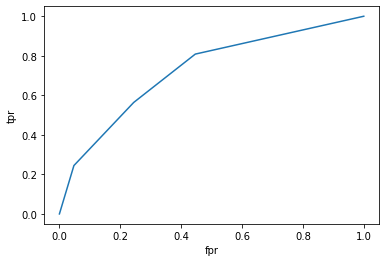

In [12]:
# plot_ROC plotting the values find from compute_ROC_coordinates_optimized
rOCc.plot_ROC(cordinates)

In [416]:
# compute_AUCROC calculating the area under the curve using the plot from plot_ROC
rOCc.compute_AUCROC(cordinates)

0.7324594731509625